In [24]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsforecast import StatsForecast
from statsforecast.models import GARCH, ARCH, Naive, AutoARIMA
from datasetsforecast.losses import mae
import warnings

In [25]:
warnings.filterwarnings("ignore")

In [26]:
tickers = ['BTC-USD', 'NVDA', 'IBM'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1d')
df.head()

[*********************100%%**********************]  3 of 3 completed


Price          Adj Close                               Close              \
Ticker           BTC-USD         IBM      NVDA       BTC-USD         IBM   
Date                                                                       
2018-01-01  13657.200195         NaN       NaN  13657.200195         NaN   
2018-01-02  14982.099609  108.470894  4.930641  14982.099609  147.466537   
2018-01-03  15201.000000  111.452530  5.255149  15201.000000  151.520081   
2018-01-04  15599.200195  113.709854  5.282848  15599.200195  154.588913   
2018-01-05  17429.500000  114.265396  5.327617  17429.500000  155.344162   

Price                        High                                Low  \
Ticker         NVDA       BTC-USD         IBM     NVDA       BTC-USD   
Date                                                                   
2018-01-01      NaN  14112.200195         NaN      NaN  13154.700195   
2018-01-02  4.98375  15444.599609  148.001907  4.98750  13163.599609   
2018-01-03  5.31175  15572.799805  152.782028  5.34250  14844.500000   
2018-01-04  5.33975  15739.700195  155.181641  5.45125  14522.200195   
2018-01-05  5.38500  17705.199219  155.736145  5.42275  15202.799805   

Price                                    Open                       \
Ticker             IBM     NVDA       BTC-USD         IBM     NVDA   
Date                                                                 
2018-01-01         NaN      NaN  14112.200195         NaN      NaN   
2018-01-02  146.787766  4.86250  13625.000000  147.705551  4.89450   
2018-01-03  149.455063  5.09375  14978.200195  150.420654  5.10250   
2018-01-04  152.361374  5.31725  15270.700195  152.629059  5.39400   
2018-01-05  154.015289  5.27700  15477.200195  155.296371  5.35475   

Price            Volume                          
Ticker          BTC-USD        IBM         NVDA  
Date                                             
2018-01-01  10291200000        NaN          NaN  
2018-01-02  16846600192  4395815.0  355616000.0  
2018-01-03  16871900160  9875914.0  914704000.0  
2018-01-04  21783199744  7903785.0  583268000.0  
2018-01-05  23840899072  5434807.0  580124000.0

In [27]:
df = df.loc[:, (['Adj Close'], tickers)]
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index()
df.head()

Ticker,Date,BTC-USD,NVDA,IBM
0,2018-01-01,13657.200195,NaN,NaN
1,2018-01-02,14982.099609,4.930641,108.470894
2,2018-01-03,15201.000000,5.255149,111.452530
3,2018-01-04,15599.200195,5.282848,113.709854
4,2018-01-05,17429.500000,5.327617,114.265396


In [28]:
prices = df.melt(id_vars = 'Date')
prices = prices.rename(columns={'Date': 'ds', 'Ticker': 'unique_id', 'value': 'y'})
prices = prices[['unique_id', 'ds', 'y']]
prices

,unique_id,ds,y
0,BTC-USD,2018-01-01,13657.200195
1,BTC-USD,2018-01-02,14982.099609
2,BTC-USD,2018-01-03,15201.000000
3,BTC-USD,2018-01-04,15599.200195
4,BTC-USD,2018-01-05,17429.500000
...,...,...,...
5470,IBM,2022-12-26,NaN
5471,IBM,2022-12-27,133.133942
5472,IBM,2022-12-28,130.890457
5473,IBM,2022-12-29,131.862610


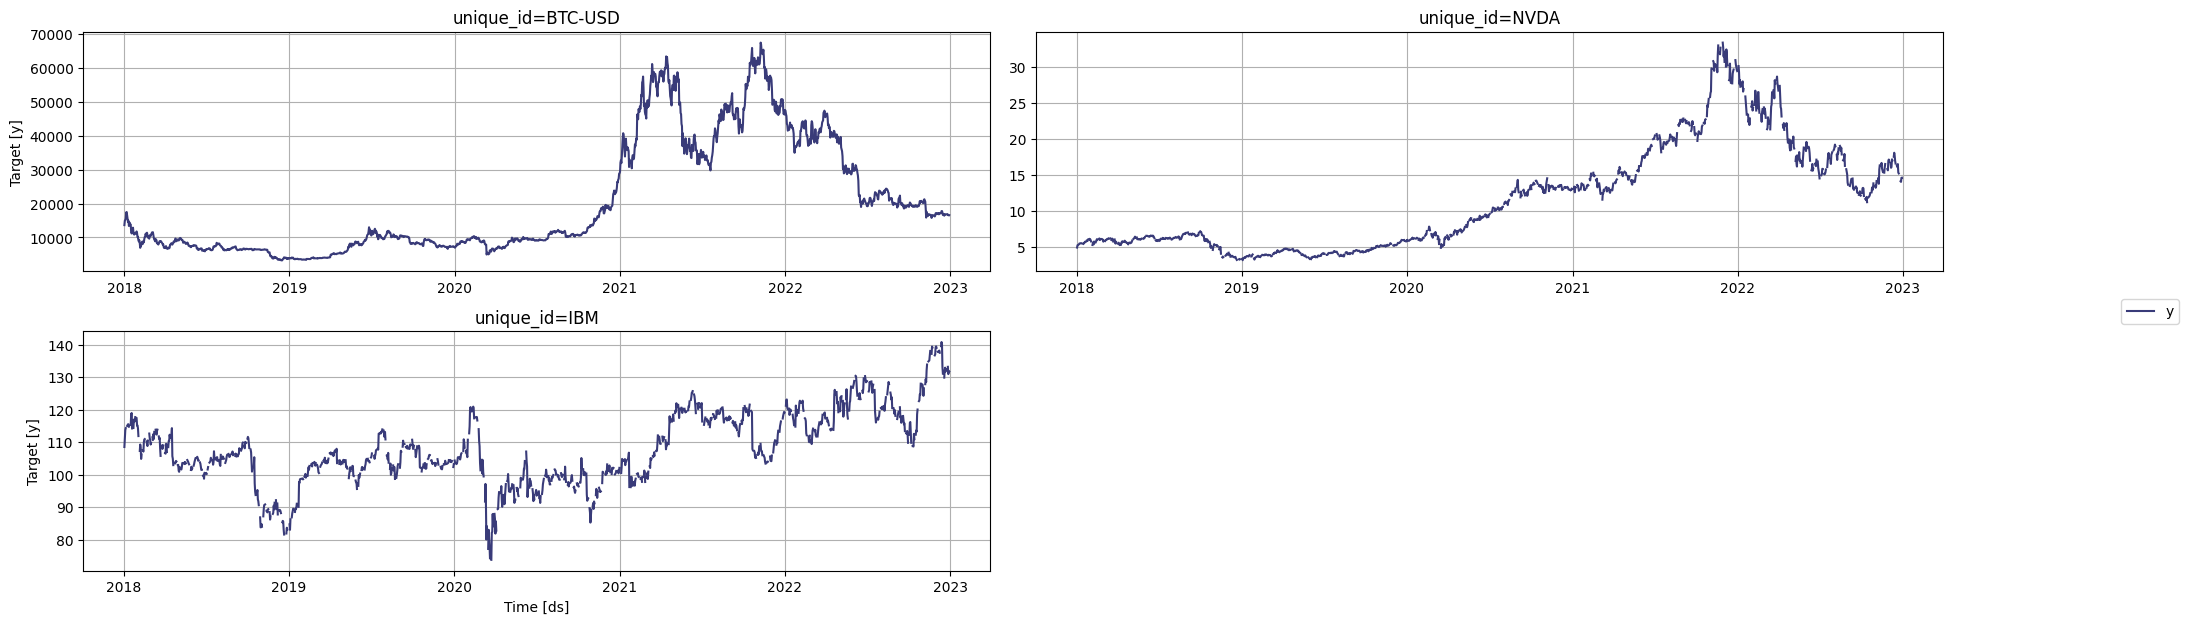

In [29]:
StatsForecast.plot(prices)

In [30]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1))
prices['rt'] = np.log(prices['rt'])

returns = prices[['unique_id', 'ds', 'rt']]
returns = returns.rename(columns={'rt':'y'})
returns


,unique_id,ds,y
0,BTC-USD,2018-01-01,NaN
1,BTC-USD,2018-01-02,0.092589
2,BTC-USD,2018-01-03,0.014505
3,BTC-USD,2018-01-04,0.025858
4,BTC-USD,2018-01-05,0.110945
...,...,...,...
5470,IBM,2022-12-26,NaN
5471,IBM,2022-12-27,NaN
5472,IBM,2022-12-28,-0.016995
5473,IBM,2022-12-29,0.007400


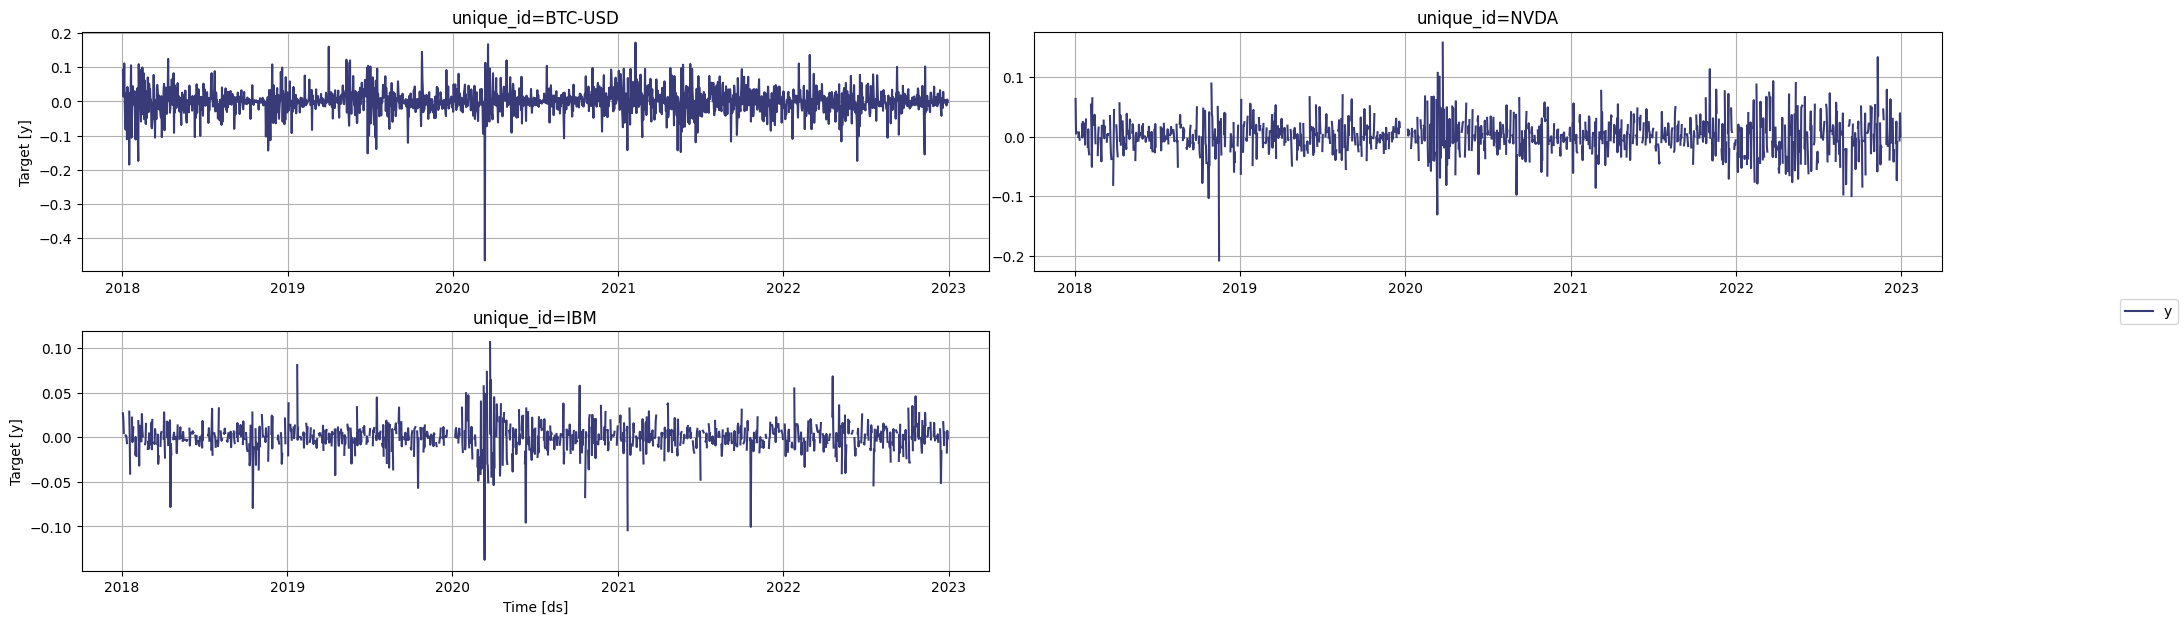

In [31]:
StatsForecast.plot(returns)

In [32]:
models = [ARCH(1), ARCH(2), GARCH(1,1), GARCH(1,2), GARCH(2,2), GARCH(2,1), AutoARIMA(), Naive()]

sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'D',
    n_jobs = -1
)

In [33]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3,
    step_size = 3,
    n_windows = 4
  )

In [34]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
0,BTC-USD,2022-12-19,2022-12-18,-0.019176,0.095834,0.059667,0.059059,0.050059,0.058937,0.332661,3.343004e-04,-0.002212
1,BTC-USD,2022-12-20,2022-12-18,0.027989,-0.036093,-0.024483,-0.024916,-0.020884,-0.023823,-0.125311,7.917105e-07,-0.002212
2,BTC-USD,2022-12-21,2022-12-18,-0.005265,-0.031161,-0.020941,-0.020664,-0.017757,-0.022049,-0.108173,0.000000e+00,-0.002212
3,BTC-USD,2022-12-22,2022-12-21,0.000761,0.195093,0.060458,0.143036,0.049728,0.057877,0.060082,1.300794e-03,-0.005265
4,BTC-USD,2022-12-23,2022-12-21,-0.001986,-0.073477,-0.024531,-0.053871,-0.020758,-0.024203,-0.023537,-1.333075e-04,-0.005265


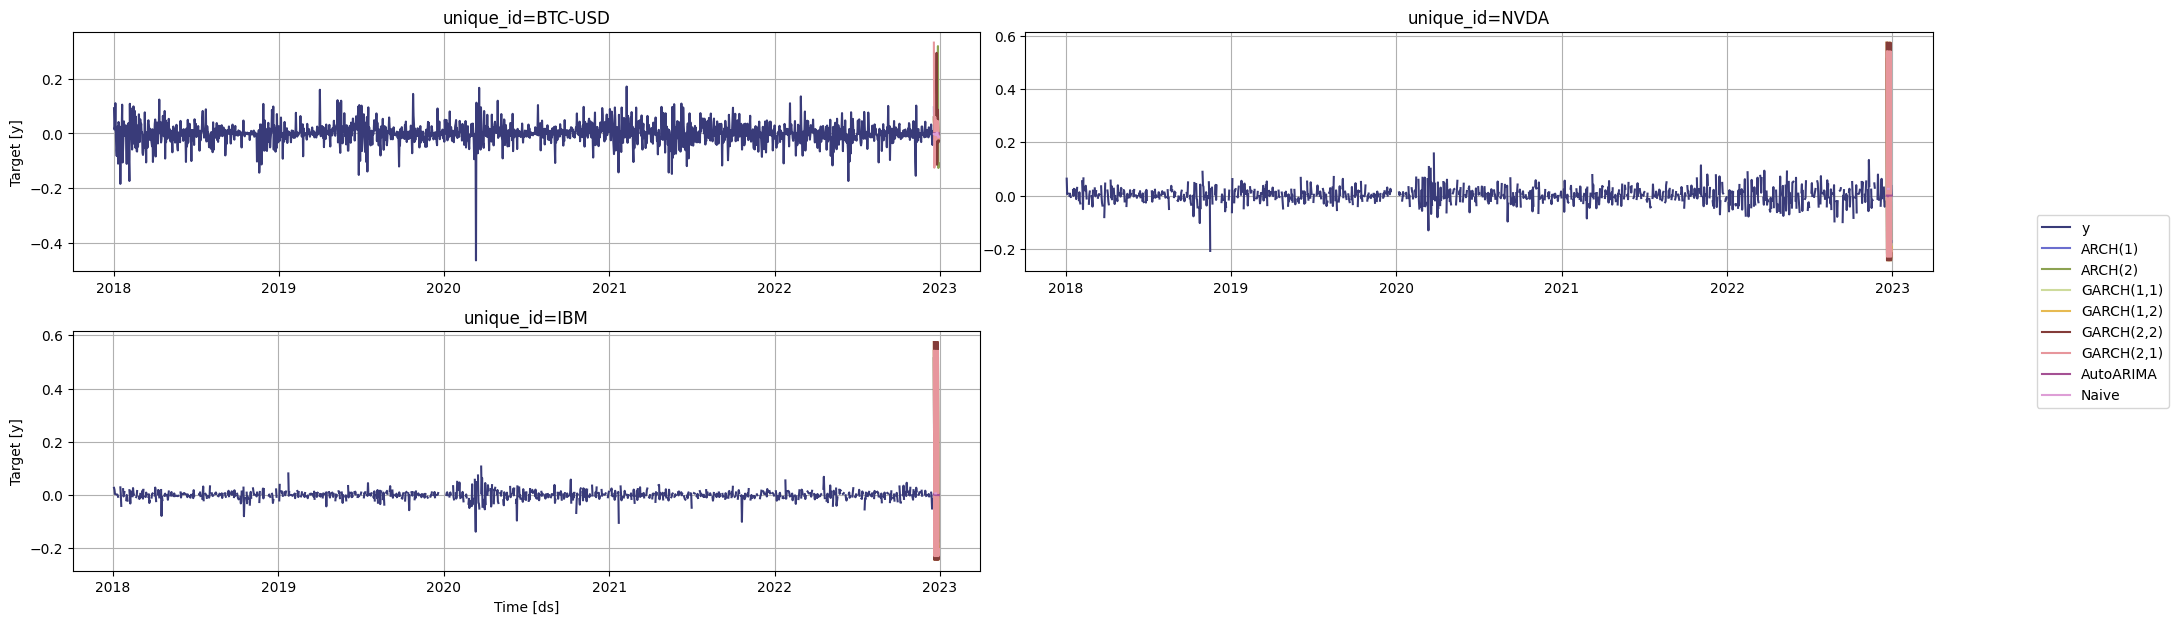

In [35]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [36]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: 
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)])
    return pd.Series(res)


mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae*100

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",AutoARIMA,Naive
unique_id,,,,,,,,
BTC-USD,6.300141,9.076052,4.792519,3.615742,7.621301,7.361011,0.781548,0.975779
IBM,29.567299,30.133257,31.181583,33.019516,33.645454,31.771502,0.868897,0.779538
NVDA,30.524094,31.090059,32.138233,33.976055,34.602222,32.728157,2.429496,6.639927
